# Système de Prévision des Ventes 

## Introduction

Ce notebook documente la construction de notre modèle prédictif pour estimer le nombre de ventes dans le contexte d'un e-commerce brésilien. Nous commencons par décrire les étapes d'analyse, d'exploration et de nettoyage de notre dataset. Ensuite, nous explorons diverses approches de modélisation tel que le modèle ARIMA et le modèle de régression linéaire, afin d'optimiser la précision des prédictions.

## Objectif

L'objectif est de construire un modèle robuste capable de prédire avec précision le temps nécessaire pour qu'une commande atteigne un client après son achat.

## I- Analyse Exploratoire des Données

Nous avons commencé par charger et explorer notre dataset. Voici les premières étapes que nous avons suivies:

## Chargement des Données

La première étape de notre processus a été la sélection et la préparation des données. Nous avons extrait des informations pertinentes à partir de différentes tables, incluant les détails des commandes, les caractéristiques des produits, et les données démographiques des clients et vendeurs. Après, on a appliqué la fusion de multiples sources de données pour créer un ensemble cohérent, en nettoyant et en structurant les données pour facilier l'analyse et la modélisation

In [1]:
import pandas as pd
from geopy.distance import geodesic

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
db_orders = pd.read_csv('archive/olist_orders_dataset.csv')
db_products = pd.read_csv('archive/olist_products_dataset.csv')
db_customers = pd.read_csv('archive/olist_customers_dataset.csv')
db_order_items = pd.read_csv('archive/olist_order_items_dataset.csv')
db_sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
db_geolocation = pd.read_csv('archive/olist_geolocation_dataset.csv')



db_orders = db_orders[['order_id', 'customer_id', 'order_purchase_timestamp', 'order_status','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']]
db_products = db_products[['product_id', 'product_category_name','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
db_customers = db_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix','customer_city', 'customer_state']]
db_order_items = db_order_items[['order_id', 'product_id', 'seller_id', 'price', 'freight_value']]
db_sellers = db_sellers[['seller_id','seller_zip_code_prefix']]


# Fusionner les colonnes pour créer un seul fichier csv
merged_df = pd.merge(db_orders, db_order_items, on='order_id', how='left')
merged_df = pd.merge(merged_df, db_products, on='product_id', how='left')
merged_df = pd.merge(merged_df, db_customers, on='customer_id', how='left')
merged_df = pd.merge(merged_df, db_sellers, on='seller_id')

## Prétraitement des Données

Notre nettoyage des données a inclus la suppression des commandes indisponibles ou annulées, et la création d'une catégorie 'Other' pour les produits qui ne possèdent pas une catégorie.

Après avoir effectué tous les nettoyages nécessaires, nous avons sauvgardé le nouveau dataset dans un fichier CSV.

In [3]:
# Les dimensions du produit
merged_df['volume_cm3'] = merged_df['product_length_cm'] * merged_df['product_height_cm'] * merged_df['product_width_cm']

#Supprimer les lignes les articles indisponible
merged_df = merged_df[merged_df['order_status'] != 'unavailable']

#Supprimer les commandes annuler
merged_df = merged_df[merged_df['order_status'] != 'canceled']

#Supprimer les commandes non livrés
merged_df = merged_df[merged_df['order_status'] != 'created']
#merged_df = merged_df[merged_df['order_status'] != 'invoiced']
#merged_df = merged_df[merged_df['order_status'] != 'shipped']
#merged_df = merged_df[merged_df['order_status'] != 'processing'


#Supprimer les commandes qui contient pas de prix ni de freight value
merged_df = merged_df.dropna(subset=['price','freight_value','product_id'])

#Remplacer les valeurs nulles dans la colonne 'product_category_name' par 'Other'
merged_df['product_category_name'].fillna('Other', inplace=True)


# Enregistrer le nouveau DataFrame fusionné dans un fichier CSV
merged_df.to_csv('Dataset_final.csv', index=False)

## Aperçu des Données

Nous allons explorer le dataset préparé pour mieux comprendre sa structure et les caractéristiques de ses données.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dt = pd.read_csv('Dataset_final.csv')

print(dt.head()) # les premières lignes de notre dataset

                           order_id                       customer_id   
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d  \
1  8736140c61ea584cb4250074756d8f3b  ab8844663ae049fda8baf15fc928f47f   
2  a0151737f2f0c6c0a5fd69d45f66ceea  fc2697314ab7fbeda62bb6f1afa4efcd   
3  a3bf941183211246f0d42ad757cba127  3718e1873d5dc3e8d96c0ab783278b02   
4  1462290799412b71be32dd880eaf4e1b  220e4b027f0294fd79d2869ef67e7db6   

  order_purchase_timestamp order_status    order_approved_at   
0      2017-10-02 10:56:33    delivered  2017-10-02 11:07:15  \
1      2017-08-10 13:35:55    delivered  2017-08-10 13:50:09   
2      2017-07-12 14:11:58    delivered  2017-07-12 14:30:18   
3      2017-07-24 22:16:25    delivered  2017-07-25 22:25:11   
4      2017-08-19 14:06:58    delivered  2017-08-22 04:10:55   

  order_delivered_carrier_date order_delivered_customer_date   
0          2017-10-04 19:55:00           2017-10-10 21:25:13  \
1          2017-08-11 13:52:35           2017-08

En affichant les premières lignes du dataset avec `dt.head`, nous pouvons rapidement observer la disposition des données, les noms des colonnes, et avoir un aperçu du type de données que chaque colonne contient. Du coup, on a pu identifier les types de données (numérique, catégorique).

In [6]:
print(dt.info()) # information générales sur le dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112101 entries, 0 to 112100
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112101 non-null  object 
 1   customer_id                    112101 non-null  object 
 2   order_purchase_timestamp       112101 non-null  object 
 3   order_status                   112101 non-null  object 
 4   order_approved_at              112086 non-null  object 
 5   order_delivered_carrier_date   111380 non-null  object 
 6   order_delivered_customer_date  110189 non-null  object 
 7   product_id                     112101 non-null  object 
 8   seller_id                      112101 non-null  object 
 9   price                          112101 non-null  float64
 10  freight_value                  112101 non-null  float64
 11  product_category_name          112101 non-null  object 
 12  product_weight_g              

In [7]:
print(dt.describe()) # Description des données (moyenne, std, min...)

               price  freight_value  product_weight_g  product_length_cm   
count  112101.000000  112101.000000     112083.000000      112083.000000  \
mean      120.377166      19.992028       2093.615187          30.154493   
std       182.637401      15.797782       3751.385096          16.153039   
min         0.850000       0.000000          0.000000           7.000000   
25%        39.900000      13.080000        300.000000          18.000000   
50%        74.900000      16.270000        700.000000          25.000000   
75%       134.900000      21.150000       1800.000000          38.000000   
max      6735.000000     409.680000      40425.000000         105.000000   

       product_height_cm  product_width_cm  customer_zip_code_prefix   
count      112083.000000     112083.000000             112101.000000  \
mean           16.584451         22.994352              35154.886914   
std            13.435684         11.700765              29871.014203   
min             2.000000   

On se retrouve avec un dataset de 22 colonnes et 112 101 lignes. Il y'a des commandes qui ne sont pas encore livrées ou acceptées (order_status= 'invoiced'/'shipped'/'processing'). On a décidé de les conserver car ils seront utiles pour la prédiction des prix, mais pour la prédiciton des délais de livraison, on va les supprimer, et laisser que les commandes livrées (possèdent un order_delivered_customer_date).

## Conversion des Dates en Format Numérique

Les colonnes de date ont été convertises en datetime et transformées en nombres de jours par rapport à une date de référence fixe. Cela permet de traiter les dates comme des valeurs numériques continues.

In [11]:
#Dataset
df = pd.read_csv ('Dataset_final.csv',sep=',')

In [12]:
date_ref = pd.Timestamp('2017-01-01')
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date','order_delivered_carrier_date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f'{col}_days'] = (df[col] - date_ref).dt.days

In [16]:
# Étape 1: Lire le fichier CSV
df = pd.read_csv('Dataset_final.csv')

# Étape 2: Grouper par 'product_id' et compter les occurrences
nb_produitAchete = df.groupby(['product_id', 'order_approved_at']).size().reset_index(name='nb_produitAchete')
merged_df = pd.merge(nb_produitAchete, db_products, on='product_id', how='left')

merged_df['annee'] = pd.to_datetime(df['order_approved_at']).dt.year
merged_df['annee'] = merged_df['annee'].fillna(0)
merged_df['annee'] = merged_df['annee'].astype(int)

# Suppression des données inutiles
merged_df = merged_df.drop(columns=['product_id', 'product_category_name', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'])

# Étape 3: Sauvegarder le résultat dans un nouveau fichier CSV
merged_df.to_csv('Dataset_test.csv', index=False)

print(merged_df.columns)

print(merged_df.head()) # les premières lignes de notre dataset

print(merged_df.info()) # information générales sur le dataset

print(merged_df.describe()) # Description des données (moyenne, std, min...)

print(f"Il y a {len(merged_df)} lignes et {len(merged_df.columns)} colonnes")

Index(['order_approved_at', 'nb_produitAchete', 'annee'], dtype='object')
     order_approved_at  nb_produitAchete  annee
0  2018-05-20 18:58:59                 1   2017
1  2017-12-12 19:32:19                 1   2018
2  2017-12-22 17:31:27                 1   2018
3  2018-08-01 22:15:19                 1   2017
4  2018-08-10 13:35:21                 1   2018
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93028 entries, 0 to 93027
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   order_approved_at  93028 non-null  object
 1   nb_produitAchete   93028 non-null  int64 
 2   annee              93028 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
None
       nb_produitAchete         annee
count      93028.000000  93028.000000
mean           1.101002   2017.218784
std            0.460706     25.621981
min            1.000000      0.000000
25%            1.000000   2017.000000
50

## Utilisation du modèle ARIMA

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  # Import pour la décomposition saisonnière
from sklearn.metrics import mean_squared_error
import itertools
from tabulate import tabulate

| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | -1.7471953868888321           |
| P-valeur       | 0.4069745474201488            |
| Conclusion     | La série est non stationnaire |


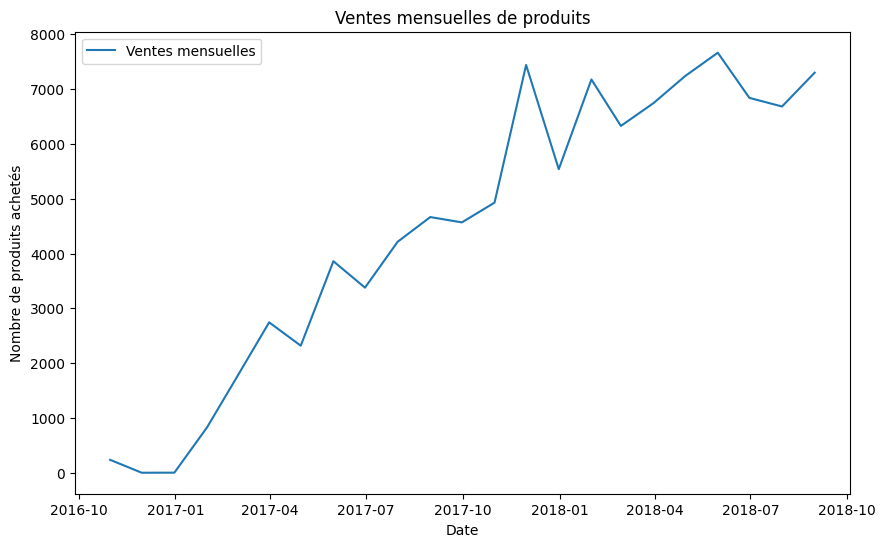

In [20]:

# Charger les données
data = pd.read_csv('Dataset_test.csv', parse_dates=['order_approved_at'])

# Prétraitement des données
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data.set_index('order_approved_at', inplace=True)

# Agréger les données par mois et par produit
monthly_data = data.resample('M').sum()

# Visualiser les ventes globales
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['nb_produitAchete'], label='Ventes mensuelles')
plt.title('Ventes mensuelles de produits')
plt.xlabel('Date')
plt.ylabel('Nombre de produits achetés')
plt.legend()
plt.show()

On cherche à trouver les paramètres optimaux pour que le modèle ARIMA puisse fonction correctement. 

Une première solution est de tester tous les paramètres possibles.

In [21]:

# Diviser les données en train et test
train = monthly_data.iloc[:-12]
test = monthly_data.iloc[-12:]

# Recherche des meilleurs paramètres ARIMA
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_params = None
for param in pdq:
    try:
        model = ARIMA(train['nb_produitAchete'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue
print(f'Best ARIMA parameters: {best_params} AIC:{best_aic}')


Best ARIMA parameters: (0, 1, 0) AIC:163.8701010403194


c:\Users\alexi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Une seconde solution est de tracer l'ACF et le PACF pour obtenir les paramètres optimaux.

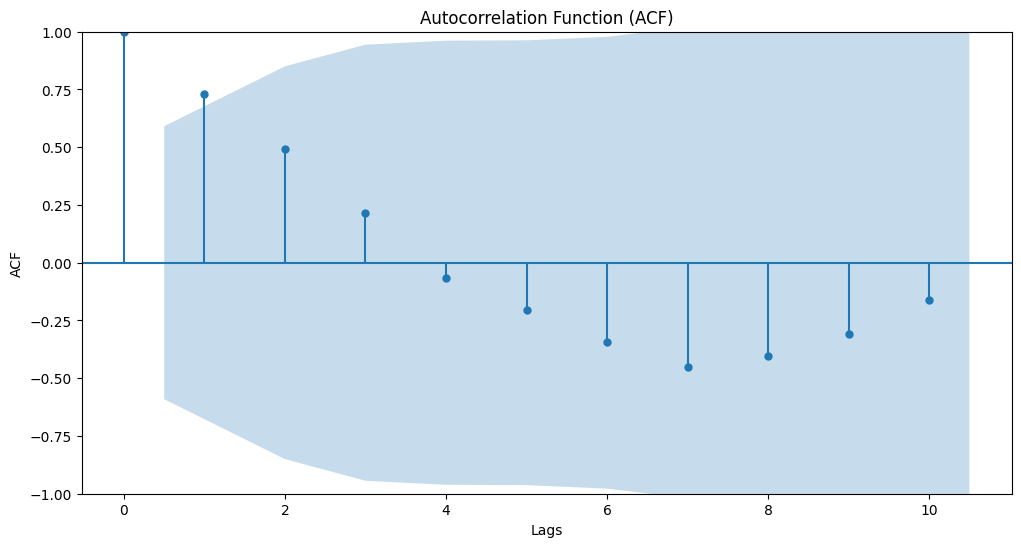

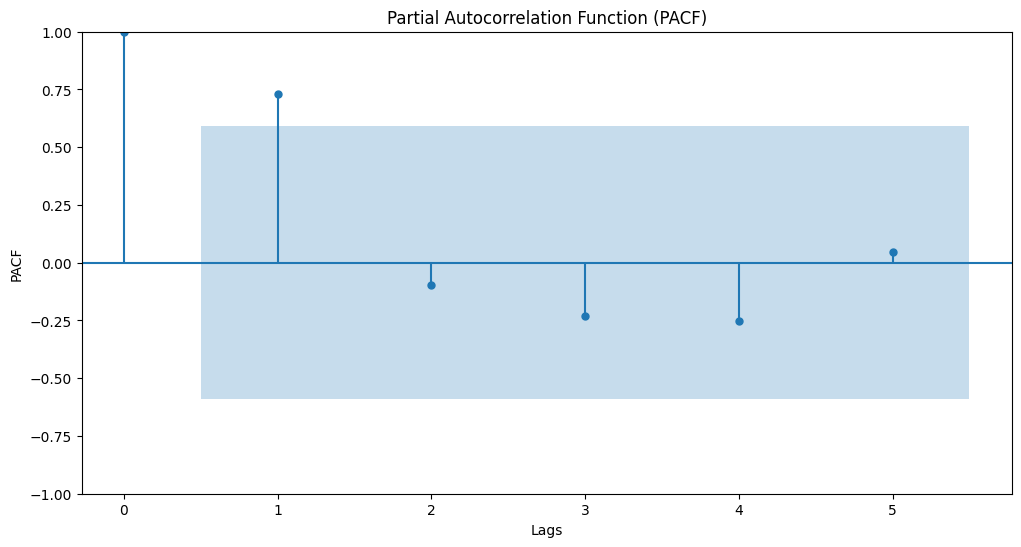

In [22]:

# Tracer l'ACF
plt.figure(figsize=(12, 6))
plot_acf(train['nb_produitAchete'], lags=min(20, len(train)-1), ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# Tracer le PACF
plt.figure(figsize=(12, 6))
plot_pacf(train['nb_produitAchete'], lags=min(10, len(train)//2), ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

Nous avons trouver les paramètres optimaux, cependant il faut savoir si notre série temporelle est stationnaire ou non, car si elle ne l'est pas, le modèle ARIMA ne pourra pas être utilisé.
Regardons.


In [46]:
result = adfuller(monthly_data['nb_produitAchete'])  # Effectuer le test de Dickey-Fuller augmenté

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur']))

Métrique        Valeur
--------------  -----------------------------
Valeur de test  -1.7471953868888321
P-valeur        0.4069745474201488
Conclusion      La série est non stationnaire


Notre série n'est pas stationnaire. Néanmoins, il existe une solution pour qu'elle puisse peut être le devenir, c'est ce qu'on appelle la différentiation. Il s'agit d'une méthode utilisée pour transformer une série temporelle afin de rendre ses caractéristiques statistiques plus stationnaires.

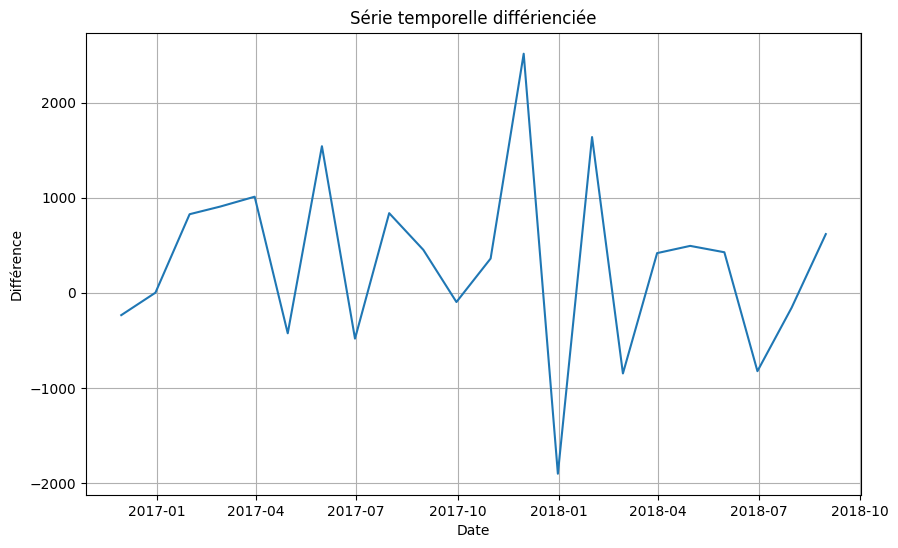

In [49]:
# Différenciation pour rendre la série stationnaire
differenced = monthly_data['nb_produitAchete'].diff().dropna()

# Afficher la série différienciée
plt.figure(figsize=(10, 6))
plt.plot(differenced)
plt.title('Série temporelle différienciée')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()


Vérifions si la série temporelle est devenue stationnaire.

In [51]:
# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur']))

Métrique        Valeur
--------------  -----------------------------
Valeur de test  1.0682698163457482
P-valeur        0.9949365098292989
Conclusion      La série est non stationnaire


La série temporelle différenciée n'est pas devenue stationnaire, il est donc impossible d'utiliser le modèle ARIMA.
Le modèle SARIMAX ou SARIMA ne peuvent pas être également utilisés.
En pratique, le modèle SARIMAX est fonctionnel cependant incohérent à nos données car il reprend la croissance des ventes de 2017 à début 2018 puis remet la même croissance après le moment où son modèle s'est arrêter de s'entrainer.

Maintenant que nous savons qu'il n'est pas possible d'utiliser des modèles de séries temporelles, nous avons décidé d'utiliser la régression linéaire comme pour la date de livraison.

## Utilisation du modèle de régression linéaire.

Erreur quadratique moyenne : 8387.471250996467
Racine de l'erreur quadratique moyenne (RMSE) : 91.58313846443824


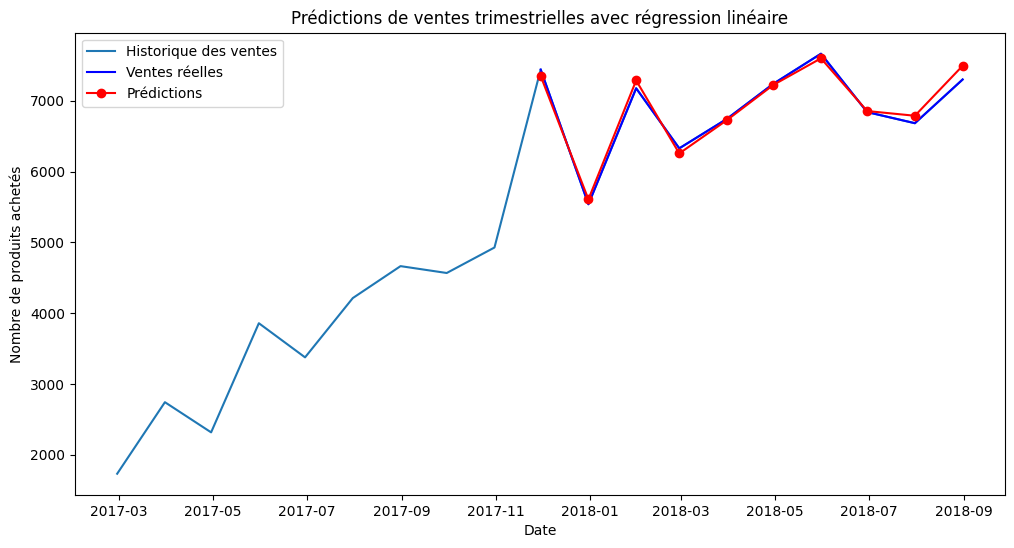

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Charger les données
data = pd.read_csv('Dataset_test.csv', parse_dates=['order_approved_at'])

# Prétraitement des données
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])
data.set_index('order_approved_at', inplace=True)

# Agréger les données par trimestre
monthly__data = data.resample('M').sum()

# Création des caractéristiques explicatives en ajoutant des lags
lags = 4  # Utilisation de 4 lags pour les mois précédents
for i in range(1, lags + 1):
    monthly__data[f'lag_{i}'] = monthly__data['nb_produitAchete'].shift(i)

# Supprimer les colonnes inutiles

# Supprimer les lignes avec des valeurs manquantes dues aux lags
monthly__data.dropna(inplace=True)

# Séparer les données en ensemble d'entraînement et de test
X = monthly__data.drop(columns=['nb_produitAchete'])
y = monthly__data['nb_produitAchete']
train_size = int(0.5 * len(monthly__data))  # 80% pour l'entraînement, 20% pour le test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Création et ajustement du modèle de régression linéaire
model = LinearRegression()

#Utilisation de l'algorithme de minimisation des moindres carrés
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f'Erreur quadratique moyenne : {mse}')
rmse = np.sqrt(mse)
print(f'Racine de l\'erreur quadratique moyenne (RMSE) : {rmse}')

# Visualisation des prédictions
plt.figure(figsize=(12, 6))
plt.plot(monthly__data.index, monthly__data['nb_produitAchete'], label='Historique des ventes')
plt.plot(y_test.index, y_test, label='Ventes réelles', color='blue')
plt.plot(y_test.index, y_pred, label='Prédictions', color='red', marker='o')
plt.title('Prédictions de ventes trimestrielles avec régression linéaire')
plt.xlabel('Date')
plt.ylabel('Nombre de produits achetés')
plt.legend()
plt.show()

Les lags dans une série temporelle fait référence aux valeurs passées de la série, ici correspondant précédents mois. Ces lags vont être utilisés en tant que features pour notre modèle de régression linéaire.

Avec un modèle de régression linéaire entrainés avec 50% des données, nous obtenons une erreur quadratique moyenne : 8387,471250996467 et une racine de l'erreur quadratique moyenne (RMSE) : 91,58313846443824.

## Validation croisée

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# Nombre de splits pour la validation croisée
n_splits = 10

# Initialisation de l'objet TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialiser une liste pour stocker les scores de validation croisée
cross_val_scores = []

# Effectuer la validation croisée
for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Création et ajustement du modèle de régression linéaire pour chaque split
    model_cv = LinearRegression()
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Prédictions sur l'ensemble de test
    y_pred_cv = model_cv.predict(X_test_cv)
    
    # Calcul de l'erreur quadratique moyenne pour ce split
    mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
    cross_val_scores.append(mse_cv)

# Calculer la moyenne des scores de validation croisée
mean_cv_score = np.mean(cross_val_scores)

print(f'Erreur quadratique moyenne en validation croisée : {mean_cv_score}')
rmse = np.sqrt(mean_cv_score)
print(f'Racine de l\'erreur quadratique moyenne (RMSE) : {rmse}')

Erreur quadratique moyenne en validation croisée : 12218.82988785984
Racine de l'erreur quadratique moyenne (RMSE) : 110.53881620435348


Avec la validation croisée, nous obtenons une erreur quadratique moyenne de 12218.82988785984 et une racine de l'erreur quadratique moyenne (RMSE) égale à 110.53881620435348